In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import sys
sys.path.append("..") # Adds higher directory to python modules path.


%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *
from DL_utils import *

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [141]:
DATA_PATH = '../data/'
QUOTATIONS = ['AMZN', 'GOOG', 'AAPL', 'GM', 'TSLA', 'JNJ', 'XOM', 'AAL', 'KO', 'WMT']
QUOTATIONS = ['JNJ']
quotation = QUOTATIONS[0]
FILE_SUFFIX = '.txt'
price_column = 'Close'
project_label='NN_LSTM_2_Classes'
normalize = True
seq_len = 10
predict_n = 1

In [142]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=normalize)

data_wrapper.head()

0        66.400002
1        67.230003
2        66.620003
3        66.510002
4        66.260002
           ...    
3520    152.470001
3521    153.190002
3522    154.139999
3523    156.050003
3524    157.380005
Name: Close, Length: 3525, dtype: float64


,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,0.166421,0.161556,0.172681,0.168113,0.102998,0.082627,0.004306,0.244899,0.018656,...,0.165782,0.158492,0.154936,0.613648,0.534115,0.582422,0.419236,lower,0.164109,lower
1,2007-02-22,0.163744,0.158535,0.169820,0.166103,0.112286,0.081448,0.013993,0.215285,0.002798,...,0.164811,0.157399,0.153680,0.610599,0.533603,0.592143,0.435595,lower,0.158422,lower
2,2007-02-23,0.160421,0.154325,0.163729,0.160347,0.098327,0.080074,0.017223,0.143903,0.015858,...,0.163277,0.156159,0.151774,0.596044,0.535462,0.575537,0.407120,lower,0.159776,higher
3,2007-02-26,0.157098,0.153227,0.163913,0.161718,0.086875,0.080883,0.025834,0.184438,0.009328,...,0.162039,0.155291,0.150316,0.606093,0.537699,0.607129,0.461296,higher,0.148493,lower
4,2007-02-27,0.154790,0.150938,0.152007,0.150297,0.170943,0.074148,0.035522,0.077134,0.027985,...,0.159743,0.153771,0.147431,0.574123,0.542334,0.550425,0.363490,lower,0.147409,lower


In [143]:
df = data_wrapper.df
feature_names = data_wrapper.feature_names
df.isna().any()

Date                   False
Open                   False
High                   False
Low                    False
Close                  False
Volume                 False
Adjusted               False
LowLen                 False
RSI(14)                False
GAP                    False
RSI_diff               False
Volume_diff            False
MACD                   False
MACD_diff              False
MACD_signal            False
BodyLen                False
BG_L_Band              False
BG_H_Band              False
BG_L_Band_Indicator    False
BG_H_Band_Indicator    False
ROC                    False
StochOsc               False
SMA(10)                False
SMA(20)                False
EMA(14)                False
EMA_Diff               False
SMA(20) - SMA(10)      False
Difference             False
PercentageDiff         False
Tendency               False
NextPrice              False
Next                   False
dtype: bool

In [144]:
from torch.utils.data import Dataset
from TorchDatasets import StocksSeqDataset

y_column = 'NextPrice'
data_columns = ['Close', 'Volume'] + feature_names
data_columns = ['MACD', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'GAP', 'Close', 'Volume', 'EMA(14)', 'SMA(10)', 'SMA(20)', 'StochOsc']
#data_columns = ['MACD', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'GAP', 'Close']
data_columns = ['Close', 'Volume', 'MACD', 'RSI(14)', 'PercentageDiff','SMA(20) - SMA(10)']
data_columns += [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':0})


    
X = dataset.loc[:, dataset.columns != y_column]
y = dataset[y_column]

X.head(), y.head()

(      Close    Volume      MACD   RSI(14)  PercentageDiff  SMA(20) - SMA(10)
 0  0.168113  0.102998  0.527891  0.244899        0.419236           0.534115
 1  0.166103  0.112286  0.524049  0.215285        0.435595           0.533603
 2  0.160347  0.098327  0.517304  0.143903        0.407120           0.535462
 3  0.161718  0.086875  0.513423  0.184438        0.461296           0.537699
 4  0.150297  0.170943  0.502745  0.077134        0.363490           0.542334,
 0    0.164109
 1    0.158422
 2    0.159776
 3    0.148493
 4    0.147409
 Name: NextPrice, dtype: float64)

In [145]:
def generate_sequences(values, seq_len):
    sequences = np.empty((values.shape[0] - seq_len, seq_len, values.shape[1]))
    for i in tqdm(range(0, sequences.shape[0])):
        seq = values[i:i+seq_len].values
        sequences[i] = seq
        
    return sequences
    

X_seq = generate_sequences(X, seq_len)
y_seq = y[seq_len:]

print(X_seq.shape, y_seq.shape)

#print(X.head(seq_len+1).values, y.head(seq_len+1).values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3481/3481 [00:00<00:00, 32234.39it/s]

(3481, 10, 6) (3481,)


In [146]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=True)
    
print(f"Train size : {len(X_train)}, test_size : {len(X_test)}")

y_test = y_test.sort_index()

Train size : 2436, test_size : 1045


In [147]:
train_dataset = StocksSeqDataset(X_train, y_train)
test_dataset = StocksSeqDataset(X_test, y_test)

print(X_train.shape)
print(X_test.shape)

(2436, 10, 6)
(1045, 10, 6)


$Seq_X = [[x_i*N_{features}], [x_{i+1} * N_{features}], ... , x_{seq_len} * N_{features}]$

$Seq_Y = [y_{seq\_len + 1}]$

In [148]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

### Model

In [167]:
import torch.nn as nn
from torch.autograd import Variable 

class LSTMModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 8),
            nn.ReLU(0.1),
            nn.BatchNorm1d(8),
            nn.Linear(8, 8),
            nn.ReLU(0.1),
            nn.Dropout(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(0.1),
            nn.Dropout(),
            nn.Linear(8, 8),
            nn.ReLU(0.1),
            nn.Linear(8, output_dim),
            #nn.Softmax(1),
        )
            
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.classifier(hn[-1])
        return out
    
lr = 0.01
model, optimizer, loss_fn = create_model(LSTMModel, device=device, input_dim = len(X.columns), output_dim=1, 
                                            loss_fn=nn.MSELoss, optimizer=torch.optim.Adam, lr=lr,
                                            use_wandb=True, project_label=project_label, hidden_dim=16, n_layers=)

train(model, train_dataloader, n_epochs=100, optimizer=optimizer, acc_func=torch_mse, acc_label="MSE", loss_fn=loss_fn, device=device, use_wandb=True)

train_loss,0.00893
train MSE,0.00725
_runtime,92
_timestamp,1619178815
_step,99


train_loss,▂▁▁▂▁▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▃▁▁▁▂▁▅▄▁▁█▂▁▁▂▁▁▁▃▁
train MSE,█▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|                                                                                                                  | 0/100 [00:00<?, ?it/s]c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get 

In [160]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

predictions, labels = predict_reg(model, test_dataloader, device)

print(labels[:10], predictions[:10])
r2 = r2_score(labels, predictions)

mse = mean_squared_error(labels, predictions)

print(f"MSE : {mse}, R2: {r2}, MAE : {mean_absolute_error(labels, predictions)}")

[0.13648675 0.12755011 0.1232172  0.12096047 0.12186314 0.13603538
 0.14217366 0.14822172 0.16555338 0.16717823] [[0.55380106]
 [0.14669272]
 [0.14716485]
 [0.15236875]
 [0.47822788]
 [0.14568275]
 [0.14879343]
 [0.77012   ]
 [0.5109019 ]
 [0.1436316 ]]
MSE : 0.14079907536506653, R2: -0.7603479797270867, MAE : 0.28885218501091003


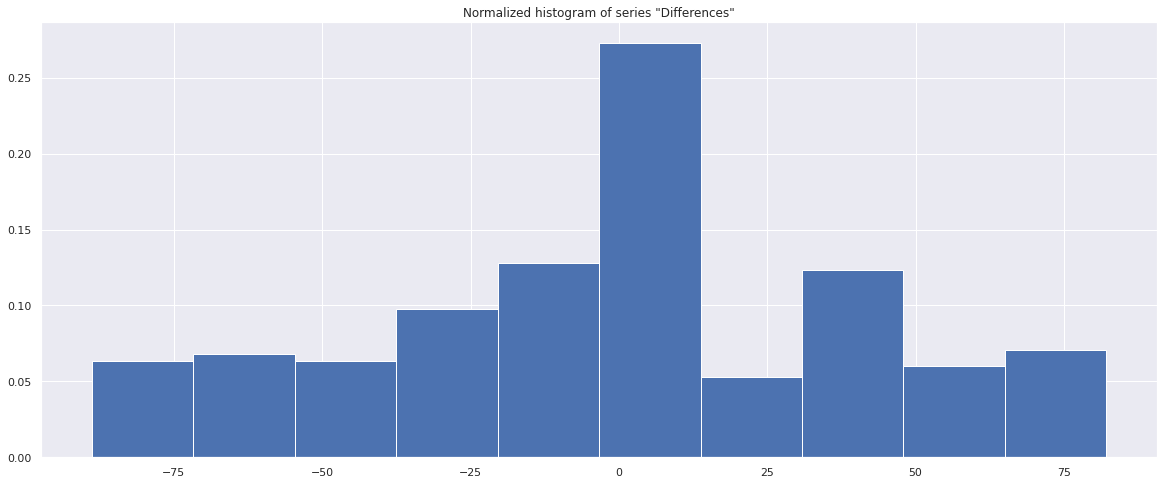

In [161]:
from StocksDataWrapper import *

test_df = pd.DataFrame(data={'Close':predictions.reshape(-1)})
scaled_preds = data_wrapper.get_unscaled_data(df=test_df)['Close']
test_df = pd.DataFrame(data={'Close':labels.reshape(-1)})
scaled_labels = data_wrapper.get_unscaled_data(df=test_df)['Close']

prices_diffs = [(p-y) for p,y in zip(scaled_preds, scaled_labels)]
ax = plot_normalized_histogram(series=pd.Series(prices_diffs, name="Differences"))

In [162]:
smoothed_predictions = pd.Series(scaled_preds).rolling(10).mean()

smoothed_predictions.replace(np.nan, 0)

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
1040    89.116001
1041    85.126469
1042    78.253442
1043    81.157181
1044    82.730603
Name: Close, Length: 1045, dtype: float64

In [163]:
print(scaled_preds[:10], scaled_labels[:10])

0    107.213527
1     62.655517
2     62.707192
3     63.276759
4     98.942042
5     62.544976
6     62.885440
7    130.889639
8    102.518217
9     62.320478
Name: Close, dtype: float64 0    61.538474
1    60.560358
2    60.086121
3    59.839122
4    59.937919
5    61.489071
6    62.160906
7    62.822866
8    64.719816
9    64.897656
Name: Close, dtype: float64


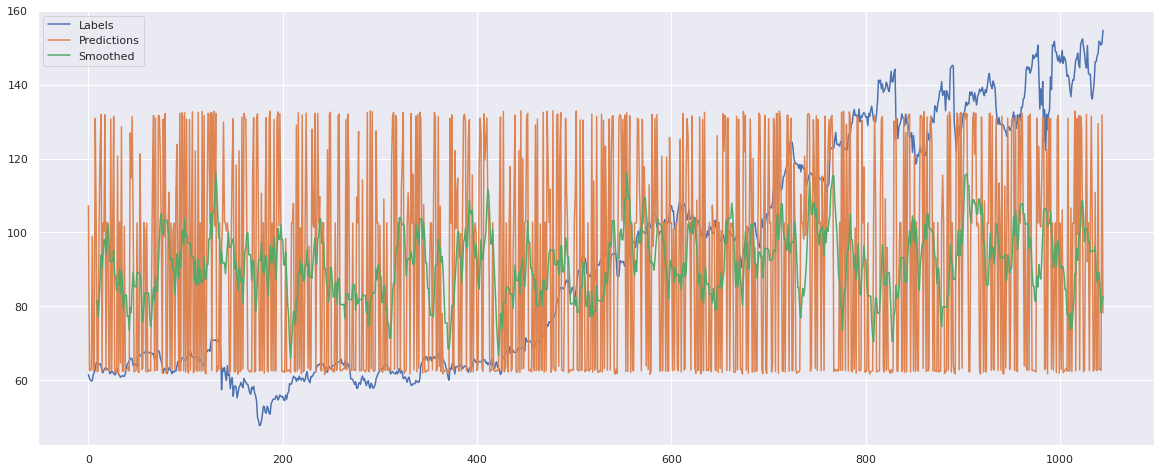

In [166]:
ax = plt.gca()
ax.plot(scaled_labels, label="Labels")
ax.plot(scaled_preds, label="Predictions")
ax.plot(smoothed_predictions, label="Smoothed")
plt.legend(loc='best')
plt.show()